In [2]:
import pandas as pd
import numpy as np
import re

# !pip install -q wordcloud
import wordcloud
import html
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from IPython.core.display import Path
import unicodedata
import seaborn as sns
!pip install ftfy
import ftfy
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00


In [5]:
contractions_dict = {
    # Common negative contractions (apostrophe removed)
    "dont": "do not", "doesnt": "does not", "didnt": "did not",
    "cant": "can not", "wont": "will not", "shouldnt": "should not",
    "couldnt": "could not", "isnt": "is not", "arent": "are not",
    "hasnt": "has not", "havent": "have not", "hadnt": "had not",
    "wouldnt": "would not", "mustnt": "must not", "wasnt": "was not",
    "werent": "were not", "mightnt": "might not", "shant": "shall not",

    # # # Common verb contractions
    "im": "i am", "youre": "you are", "ure":"you are", "hes": "he is", "shes": "she is",
    "its": "it is", "were": "we are", "theyre": "they are",
    "thats": "that is", "whats": "what is", "wheres": "where is",
    "whos": "who is", "hows": "how is", "heres": "here is",
    "theres": "there is",

    # Past tense verb contractions
    "ive": "i have", "youve": "you have", "uve":"you have","weve": "we have", "theyve": "they have",
    "whove": "who have", "whatve": "what have", "whereve": "where have",
    "howve": "how have",

    # # Future tense contractions
    "ill": "i will", "youll": "you will", "ull":"you will", "hell": "he will",
    "shell": "she will", "itll": "it will", "well": "we will",
    "theyll": "they will", "wholl": "who will", "whatll": "what will",
    "wherell": "where will", "howll": "how will",

    # Conditional contractions
    "id": "i would", "youd": "you would", "ud":"you would","hed": "he would",
    "shed": "she would", "itd": "it would", "wed": "we would",
    "theyd": "they would", "whod": "who would", "whatd": "what would",
    "whered": "where would", "howd": "how would",

    # Informal contractions
    "gimme": "give me", "gonna": "going to", "gota": "got to",
    "lemme": "let me", "wanna": "want to", "hafta": "have to",
     "dunno": "do not know", "yall": "you all", "cmon": "come on",
     "aint": "is not"
}


def replace_mentions(text):
    """Replaces @mentions with the keyword 'username', even if after punctuation."""
    return  re.sub(r'\@\w+', ' username ', text)

def remove_numbers(text):
    return re.sub(r"\b\d+\b", "", text)

def handle_negation(text):
    negation_words = {
        "not", "no", "never", "none", "nobody", "nothing",
        "nowhere", "neither", "nor", "without", "hardly",
        "scarcely", "barely", "nope", "non", "noone"
    }

    skip_words = {"too", "very", "also", "that", "the","an","be","sm","being", "been","even"}

    words = text.split()
    new_words = []
    negate_next = False

    for word in words:
        cleaned = re.sub(r"[^\w\s]", "", word).lower()

        if cleaned in negation_words:
            new_words.append(word)
            negate_next = True
        elif negate_next:
            if cleaned in skip_words:
                new_words.append(word)
                continue  # still look for next word to negate
            else:
                new_words.append(f"not_{word}")
                negate_next = False  # done negating
        else:
            new_words.append(word)

    return " ".join(new_words)

def replace_emoticon(text):
    text = re.sub(r"<3", " love ", text)
    text = re.sub(r"<33", " love ", text)
    text = re.sub(r"</33", " heartbroken ", text)
    text = re.sub(r"</3", " heartbroken ", text)
    text = re.sub(r";\)", " wink ", text)
    text = re.sub(r";-\)", " playful ", text)
    text = re.sub(r":-d", " laugh ", text)
    text = re.sub(r"\(:", " smile ", text)
    text = re.sub(r":P", " playful ", text)
    text = re.sub(r":\*", " kiss ", text)
    text = re.sub(r":'\(", " sad ", text)
    text = re.sub(r":\|", " neutral ", text)
    text = re.sub(r" :o ", " wow ", text)
    text = re.sub(r"&", " and ", text)
    text = text.replace("♥", " heart ")
    text = text.replace("♫", " music ")
    text = text.replace("☺", " smile ")
    text = re.sub(r"\bw\/out\b", " without ", text)
    text = re.sub(r"\bw\/o\b", " without ", text)
    text = re.sub(r"\bw\/(?=\s|\w)", " with ", text)
    text = re.sub(r"\bw\b", " with ", text)
    text = re.sub(r"\bb\/c\b", " because ", text)
    text = re.sub(r"\bh\/w\b", " homework ", text)
    text = re.sub(r"\bno\s*-\s*one\b", " noone ", text)
    text = re.sub(r"\bb\s*-\s*day\b", " birthday ", text)
    text = re.sub(r"\bhell\b", " xhellx ", text)
    return text

def remove_specific_punctuation(text):
    return re.sub(r"[\'@*]", "", text)

def replace_punctuation_with_space(text):
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"[_]", " ", text)
    return text


def fix_mojibake(text):
    return ftfy.fix_text(text)

slang_dict = {
    "luv": "love",
     "luvv": "love",
    "xoxo": "kiss",
    "bc" : "because",
    "bcuz": "because",
    "cuze": "because",
    "cuz": "because",
    "lil": "little",
    "fam": "family",
    "bro": "brother",
    "sis": "sister",
    "thang": "thing",
    "aint": "is not",
    "tryna": "trying to",
    "neva": "never",
    "bday": "birthday",
    "gr8": "great",
    "4ever": "forever",
    "nvm": "never mind",
    "r" : "are",
    "tryin": "trying",
    "2morow" : "tomorrow",
    "2moro" : "tomorrow",
    "morow" : "tomorrow",
    "tmrw" : "tomorrow",
    "tmrow" : "tomorrow",
    "2morow" : "tomorrow",
    "2morro" : "tomorrow",
    "morrow" : "tomorrow",
    "tmrrw" : "tomorrow",
    "tmrrow" : "tomorrow",
    "b4" : "before",
    "every1" : "everyone",
    "2nd" : "second",
     "h8" : "hate",
    "ppl" : "people",
    "ly" : "love you",
    "2nite" : "tonight",
    "2night" : "tonight",
    "tonite" : "tonight",
    "bday" : "birthday",
    "2day" : "today",
   "1st" : "first",
    "3rd" : "third",
    "str8" : "straight",
    "fk" : "fuck",
    "fkin" : "fucking",
    "fck" : "fuck",
    "fcking": "fucking",
    "fuckin": "fucking",
    "wit": "with",
    "fri":"friday",
    "friggin": "fucking",
    "frigging": "fucking",
    "lovin": "loving",
    "luving": "loving",
   "missin": "missing",
   "freakin":"freaking",
   "killin":"killing",
    "wat":"what",
   "em":"them",
   "hatin" : "hating",
    "recieve": "receive",
    "seperated": "separated",
    "wierd": "weird",
    "loosing": "losing",
    "thier": "their",
    "thx": "thanks",
    "ty": "thank you",
    "pls": "please",
    "plz": "please",
    "skool":"school",
    "frnd":"friend",
    "frnds":"friends",
    "belive":"believe",
    "seein":"seeing",
    "kno":"know",
    "icant":"i cant",
    "bein":"being",
    "bout":"about",
    "wen":"when",
    "jst":"just",
}
def replace_slang(text):
    words = text.split()
    replaced_words = [slang_dict.get(word, word) for word in words]
    return " ".join(replaced_words)

def clean_xoxo_words(text):
    """Removes the rest of a word if it starts with 'haha'."""
    return re.sub(r"\b(xoxo)[a-zA-Z0-9_]*", r"\1", text)

def replace_xx(text):
    return re.sub(r"\sxx", ' kiss ', text)

def remove_short_words(text):
    return ' '.join(word for word in text.split() if len(word) > 1)

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def replace_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', ' url ', text)

def reduce_repeated_letters_to_two(word):
    return re.sub(r"(.)\1{2,}", r"\1\1", word)

def expand_contractions(text):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text)


def clean_text(text):
    text = fix_mojibake(text)

    text = text.lower()
 
    text = replace_urls(text)
    text = replace_mentions(text)

    text = reduce_repeated_letters_to_two(text)
    text = replace_xx(text)
    text = clean_xoxo_words(text)

    text = replace_emoticon(text)

    text = re.sub(r"\b50\s*%|\b50\s*percent\b", "half", text)
    text = re.sub(r"\b100\s*%|\b100\s*percent\b", "all", text)
    text = re.sub(r"\b25\s*%|\b25\s*percent\b", "quarter", text)
    text = re.sub(r"\b0\s*%|\b0\s*percent\b", "zero", text)


    text = remove_specific_punctuation(text)
    text = replace_punctuation_with_space(text)
    text = remove_extra_spaces(text)
    text = replace_slang(text)
    text = remove_numbers(text)
    text = remove_short_words(text)
    text = remove_extra_spaces(text)
    text = expand_contractions(text)
    
    text = handle_negation(text)
    text = remove_short_words(text)
 
    return text

In [6]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/test_dataset.csv")

train_df['Text'] = train_df['Text'].apply(clean_text)
val_df['Text'] = val_df['Text'].apply(clean_text)
test_df['Text'] = test_df['Text'].apply(clean_text)

train_df.to_csv("train_cleaned.csv")
val_df.to_csv("val_cleaned.csv")
test_df.to_csv("test_cleaned.csv")

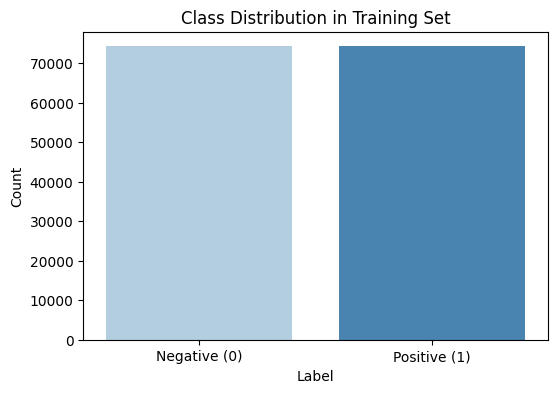

Class Distribution in Training Set:
Label
1    74196
0    74192
Name: count, dtype: int64


In [44]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")

class_counts = train_df["Label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues")
plt.xticks(ticks=[0,1], labels=["Negative (0)", "Positive (1)"])
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.show()

print("Class Distribution in Training Set:")
print(class_counts)

#plt.savefig("train_class_distribution_before.png")


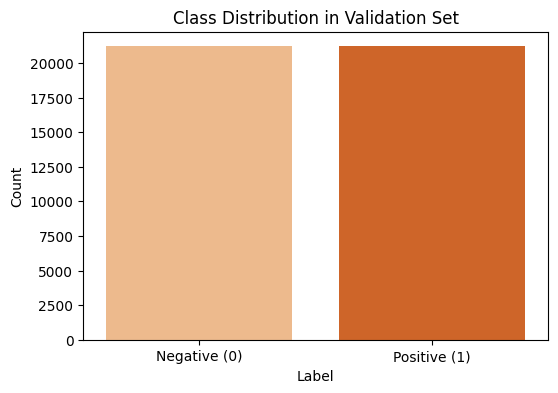

Class Distribution in Validation Set:
Label
1    21199
0    21197
Name: count, dtype: int64


In [45]:
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

val_class_counts = val_df["Label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=val_class_counts.index, y=val_class_counts.values, palette="Oranges")
plt.xticks(ticks=[0,1], labels=["Negative (0)", "Positive (1)"])
plt.ylabel("Count")
plt.title("Class Distribution in Validation Set")
plt.show()

print("Class Distribution in Validation Set:")
print(val_class_counts)

Average Tweet Length (Training Set): 13.29 words
Average Tweet Length (Validation Set): 13.31 words


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


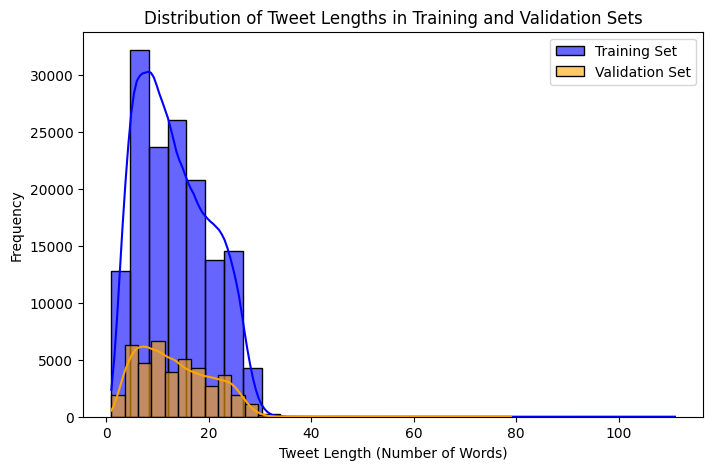

In [46]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

train_df["tweet_length"] = train_df["Text"].apply(lambda x: len(x.split()))
val_df["tweet_length"] = val_df["Text"].apply(lambda x: len(x.split()))

avg_tweet_length_train = np.mean(train_df["tweet_length"])
avg_tweet_length_val = np.mean(val_df["tweet_length"])

print(f"Average Tweet Length (Training Set): {avg_tweet_length_train:.2f} words")
print(f"Average Tweet Length (Validation Set): {avg_tweet_length_val:.2f} words")

plt.figure(figsize=(8,5))
sns.histplot(train_df["tweet_length"], bins=30, kde=True, color="blue", label="Training Set", alpha=0.6)
sns.histplot(val_df["tweet_length"], bins=30, kde=True, color="orange", label="Validation Set", alpha=0.6)
plt.xlabel("Tweet Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths in Training and Validation Sets")
plt.legend()
plt.show()

Average Tweet Length (Training Set): 12.74 words
Average Tweet Length (Validation Set): 12.76 words


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


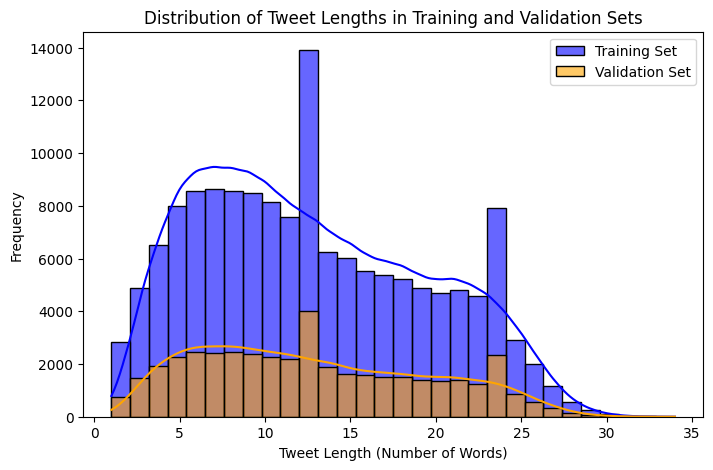

In [47]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

train_df["tweet_length"] = train_df["Text"].apply(lambda x: len(x.split()))
val_df["tweet_length"] = val_df["Text"].apply(lambda x: len(x.split()))

avg_tweet_length_train = np.mean(train_df["tweet_length"])
avg_tweet_length_val = np.mean(val_df["tweet_length"])

print(f"Average Tweet Length (Training Set): {avg_tweet_length_train:.2f} words")
print(f"Average Tweet Length (Validation Set): {avg_tweet_length_val:.2f} words")

plt.figure(figsize=(8,5))
sns.histplot(train_df["tweet_length"], bins=30, kde=True, color="blue", label="Training Set", alpha=0.6)
sns.histplot(val_df["tweet_length"], bins=30, kde=True, color="orange", label="Validation Set", alpha=0.6)
plt.xlabel("Tweet Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths in Training and Validation Sets")
plt.legend()
plt.show()

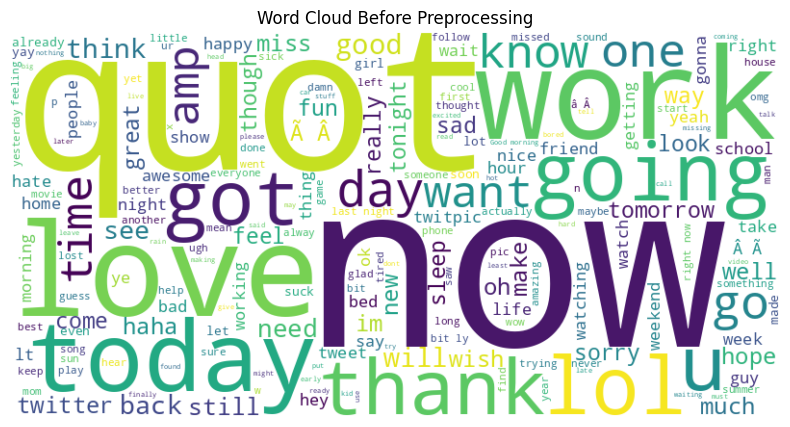

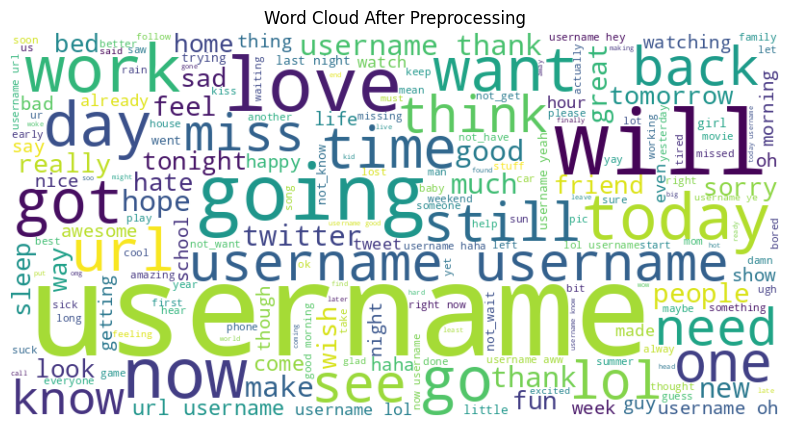

In [48]:
original_train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")  
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")

original_text = " ".join(original_train_df["Text"])
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(original_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_before, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Before Preprocessing")
#plt.savefig("wordcloud_train_before.png")
plt.show()

cleaned_text = " ".join(train_df["Text"])
wordcloud_after = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_after, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud After Preprocessing")
#plt.savefig("wordcloud_train_after.png")
plt.show()


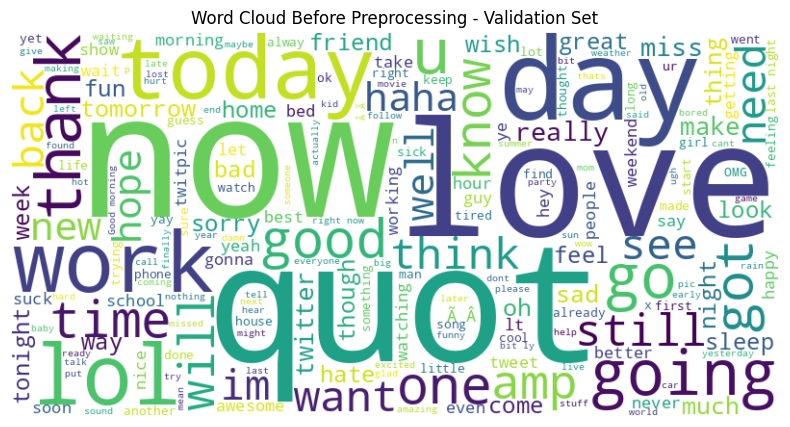

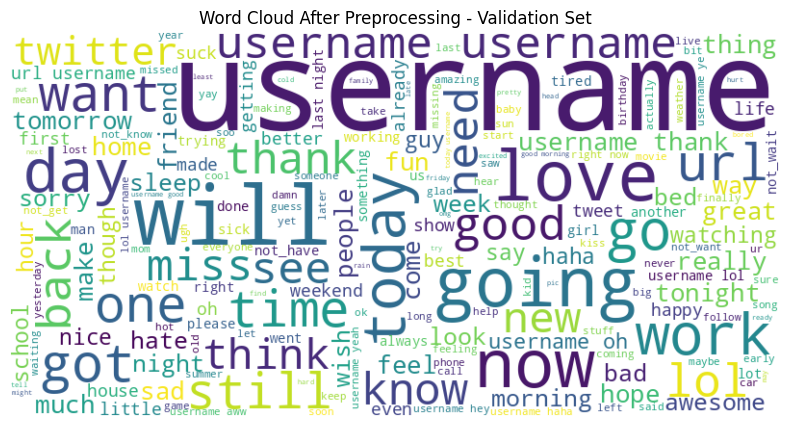

In [49]:
original_val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

original_text = " ".join(original_val_df["Text"])
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(original_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_before, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Before Preprocessing - Validation Set")
#plt.savefig("wordcloud_val_before.png")
plt.show()

cleaned_text = " ".join(val_df["Text"])
wordcloud_after = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_after, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud After Preprocessing - Validation Set")
plt.savefig("wordcloud_val_after.png")
plt.show()


In [50]:
def get_ngrams(text_series, ngram_range=(2,2), top_n=15):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(text_series) 
    ngram_counts = X.sum(axis=0).A1 
    ngrams = vectorizer.get_feature_names_out()
    df = pd.DataFrame({"N-gram": ngrams, "Frequency": ngram_counts})
    return df.sort_values(by="Frequency", ascending=False).head(top_n)


original_train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv") 
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")

bigrams_original = get_ngrams(original_train_df["Text"], ngram_range=(2,2), top_n=15)
bigrams_cleaned = get_ngrams(train_df["Text"], ngram_range=(2,2), top_n=15)

trigrams_original = get_ngrams(original_train_df["Text"], ngram_range=(3,3), top_n=15)
trigrams_cleaned = get_ngrams(train_df["Text"], ngram_range=(3,3), top_n=15)


bigram_df = pd.concat([
    bigrams_original.rename(columns={"N-gram": "Bigram (Before)", "Frequency": "Frequency (Before)"}).reset_index(drop=True),
    bigrams_cleaned.rename(columns={"N-gram": "Bigram (After)", "Frequency": "Frequency (After)"}).reset_index(drop=True)
], axis=1).fillna(0)


bigram_df.to_csv("bigram_frequencies.csv", index=False)

trigram_df = pd.concat([
    trigrams_original.rename(columns={"N-gram": "Trigram (Before)", "Frequency": "Frequency (Before)"}).reset_index(drop=True),
    trigrams_cleaned.rename(columns={"N-gram": "Trigram (After)", "Frequency": "Frequency (After)"}).reset_index(drop=True)
], axis=1).fillna(0)

trigram_df.to_csv("trigram_frequencies.csv", index=False)


In [51]:
original_val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")  
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")
bigrams_original = get_ngrams(original_val_df["Text"], ngram_range=(2,2), top_n=15)
bigrams_cleaned = get_ngrams(val_df["Text"], ngram_range=(2,2), top_n=15)

trigrams_original = get_ngrams(original_val_df["Text"], ngram_range=(3,3), top_n=15)
trigrams_cleaned = get_ngrams(val_df["Text"], ngram_range=(3,3), top_n=15)

bigram_df = pd.concat([
    bigrams_original.rename(columns={"N-gram": "Bigram (Before)", "Frequency": "Frequency (Before)"}).reset_index(drop=True),
    bigrams_cleaned.rename(columns={"N-gram": "Bigram (After)", "Frequency": "Frequency (After)"}).reset_index(drop=True)
], axis=1).fillna(0) 

bigram_df.to_csv("bigram_frequencies_val.csv", index=False)

trigram_df = pd.concat([
    trigrams_original.rename(columns={"N-gram": "Trigram (Before)", "Frequency": "Frequency (Before)"}).reset_index(drop=True),
    trigrams_cleaned.rename(columns={"N-gram": "Trigram (After)", "Frequency": "Frequency (After)"}).reset_index(drop=True)
], axis=1).fillna(0) 

trigram_df.to_csv("trigram_frequencies_val.csv", index=False)

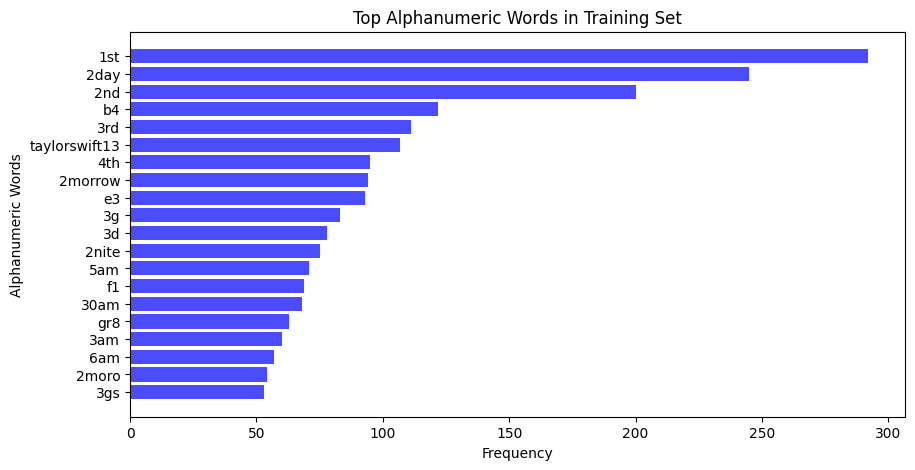

In [52]:
original_train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv") 

def extract_alphanumeric_words(text_series, top_n=25):
    word_pattern = re.compile(r'\b(?=[A-Za-z]*\d)(?=\d*[A-Za-z])[A-Za-z0-9]+\b') 
    word_counts = collections.Counter()

    for text in text_series.dropna():
        words = word_pattern.findall(text.lower()) 
        word_counts.update(words) 

    return word_counts.most_common(top_n)  

top_alphanumeric_train = extract_alphanumeric_words(original_train_df["Text"], top_n=20)

df_alphanumeric_train = pd.DataFrame(top_alphanumeric_train, columns=["Alphanumeric Word", "Frequency"])

plt.figure(figsize=(10, 5))
plt.barh(df_alphanumeric_train["Alphanumeric Word"], df_alphanumeric_train["Frequency"], color="blue", alpha=0.7)
plt.xlabel("Frequency")
plt.ylabel("Alphanumeric Words")
plt.title("Top Alphanumeric Words in Training Set")
plt.gca().invert_yaxis() 
#plt.savefig("alphanumeric_train.png")  
plt.show()

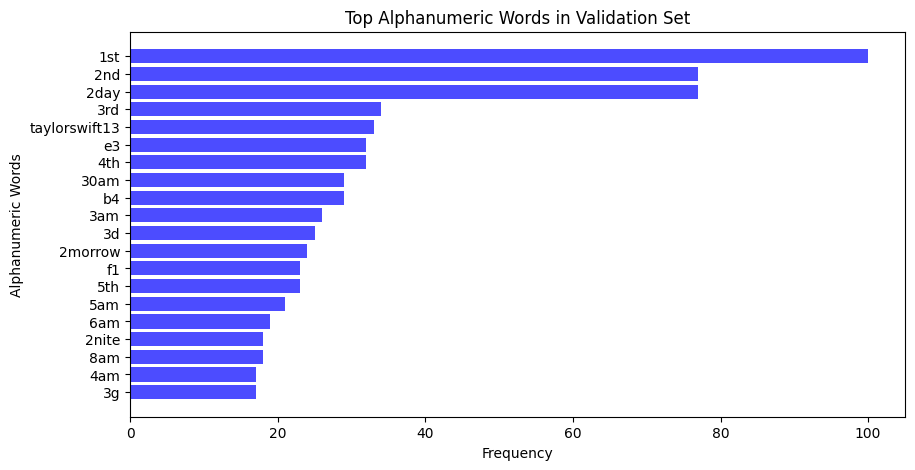

In [53]:
original_val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")  

top_alphanumeric_val = extract_alphanumeric_words(original_val_df["Text"], top_n=20)

df_alphanumeric_val = pd.DataFrame(top_alphanumeric_val, columns=["Alphanumeric Word", "Frequency"])

plt.figure(figsize=(10, 5))
plt.barh(df_alphanumeric_val["Alphanumeric Word"], df_alphanumeric_val["Frequency"], color="blue", alpha=0.7)
plt.xlabel("Frequency")
plt.ylabel("Alphanumeric Words")
plt.title("Top Alphanumeric Words in Validation Set")
plt.gca().invert_yaxis() 
#plt.savefig("alphanumeric_val.png") 
plt.show()

In [54]:
original_train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
def count_html_entities(text_series):
    entity_pattern = re.compile(r'&[a-zA-Z]+;')
    entity_counts = Counter()

    for text in text_series.dropna():
        matches = entity_pattern.findall(text)
        entity_counts.update(matches)

    return entity_counts

html_entity_counts = count_html_entities(original_train_df["Text"])

html_entity_df = pd.DataFrame(html_entity_counts.items(), columns=["HTML Entity", "Frequency"]).sort_values(by="Frequency", ascending=False)

print(html_entity_df.head(10))

  HTML Entity  Frequency
0      &quot;       6801
1       &amp;       4559
2        &lt;       1759
3        &gt;        669


In [55]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")


print("Training Set Analysis - Before")
print("Total samples:", len(train_df))
print("Average text length:", train_df["Text"].str.len().mean())
print("Unique words:", len(set(" ".join(train_df["Text"]).split())))


print("Validation Set Analysis - Before")
print("Total samples:", len(val_df))
print("Average text length:", val_df["Text"].str.len().mean())
print("Unique words:", len(set(" ".join(val_df["Text"]).split())))

# after cleaning
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

print("Training Set Analysis - After")
print("Total samples:", len(train_df))
print("Average text length:", train_df["Text"].str.len().mean())
print("Unique words:", len(set(" ".join(train_df["Text"]).split())))


print("Validation Set Analysis - After")
print("Total samples:", len(val_df))
print("Average text length:", val_df["Text"].str.len().mean())
print("Unique words:", len(set(" ".join(val_df["Text"]).split())))

Training Set Analysis - Before
Total samples: 148388
Average text length: 74.7687885812869
Unique words: 234492
Validation Set Analysis - Before
Total samples: 42396
Average text length: 74.85729785828852
Unique words: 90519
Training Set Analysis - After
Total samples: 148388
Average text length: 67.52393724559937
Unique words: 69936
Validation Set Analysis - After
Total samples: 42396
Average text length: 67.65201905840173
Unique words: 33406


In [56]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train_df['Text']) 
y_train = train_df['Label']
X = tfidf.transform(val_df['Text'])  
Y = val_df['Label']

quick_model = LogisticRegression(random_state=42, max_iter=1500).fit(x_train, y_train)
y_val_pred = quick_model.predict(X)


accuracy = accuracy_score(Y, y_val_pred)
precision = precision_score(Y, y_val_pred, average='macro')
recall = recall_score(Y, y_val_pred, average='macro')
f1 = f1_score(Y, y_val_pred, average='macro')

average_metric = (accuracy + precision + recall + f1) / 4

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Average:   {average_metric:.4f}")

Accuracy:  0.7995
Precision: 0.7996
Recall:    0.7995
F1 Score:  0.7995
Average:   0.7995


In [57]:
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation score')
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


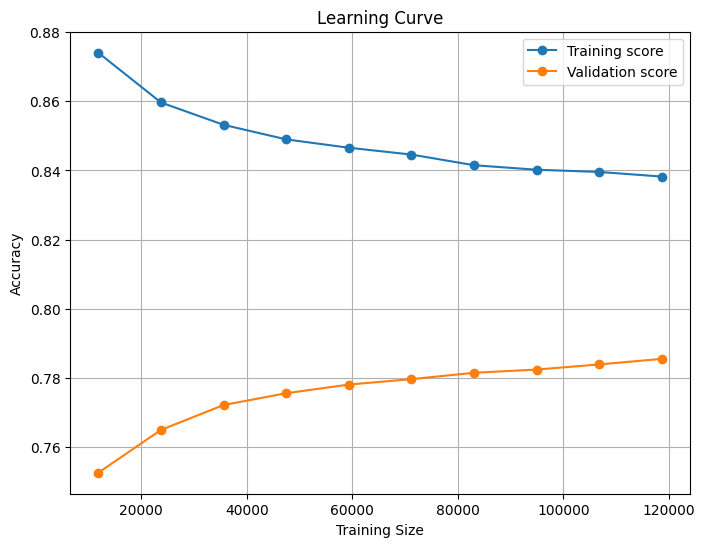

In [58]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
clf = LogisticRegression(max_iter=1500)
plot_learning_curve(clf, X_tfidf, y_train, cv=5, scoring='accuracy')

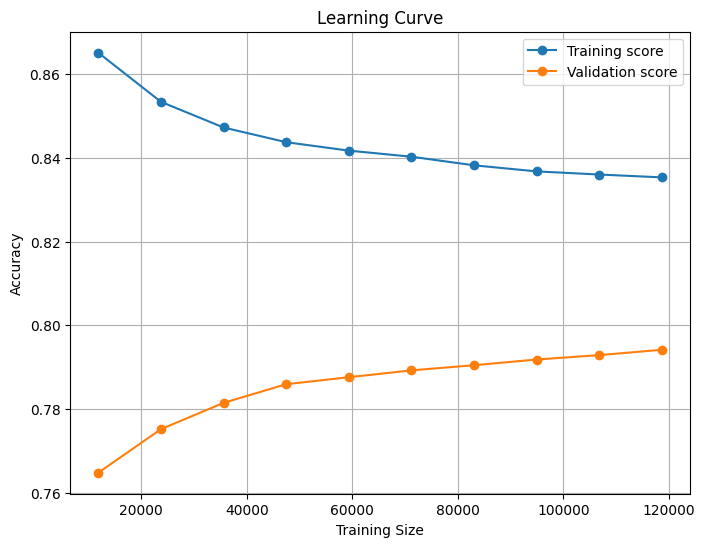

In [59]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
clf = LogisticRegression(max_iter=1500)
plot_learning_curve(clf, X_tfidf, y_train, cv=5, scoring='accuracy')


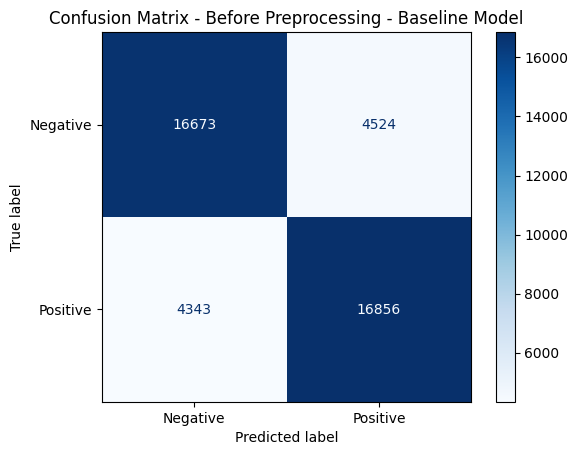

In [60]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
clf = LogisticRegression(max_iter=1500, random_state=42).fit(X_tfidf, y_train)
y_true = y_val
y_pred = clf.predict(X_val)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Before Preprocessing - Baseline Model")
plt.savefig("baseline_before_pre_confusion_matrix.png")  # Save it for LaTeX
plt.show()


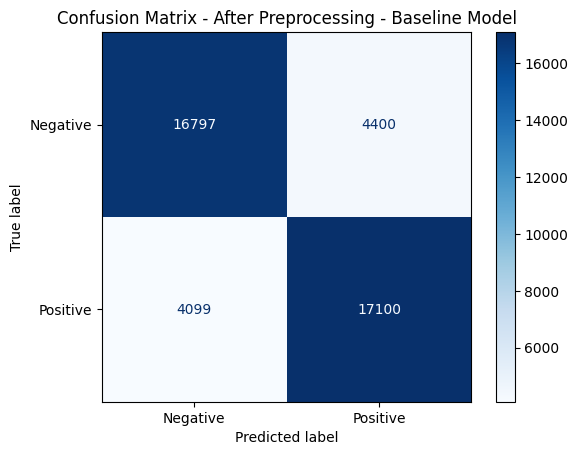

In [61]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
clf = LogisticRegression(max_iter=1500, random_state=42).fit(X_tfidf, y_train)
y_true = y_val 
y_pred = clf.predict(X_val)  

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - After Preprocessing - Baseline Model")
plt.savefig("baseline_after_pre_confusion_matrix.png")  # Save it for LaTeX
plt.show()


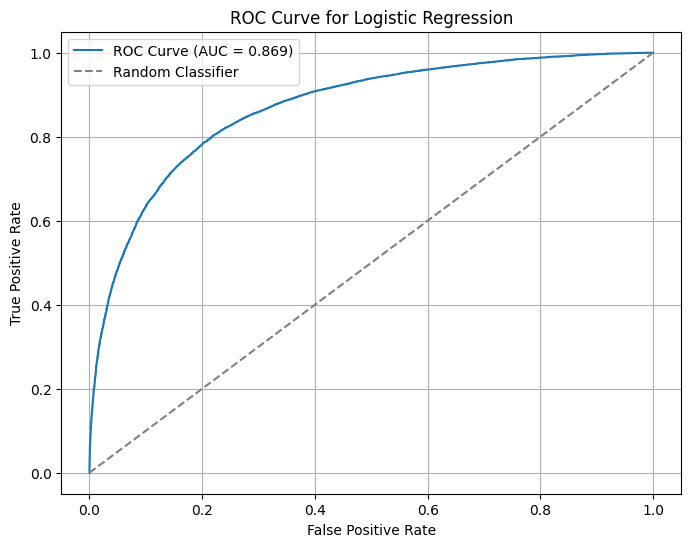

In [62]:
train_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
clf = LogisticRegression(max_iter=1500, random_state=42).fit(X_tfidf, y_train)
y_val_probs = clf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
auc_score = roc_auc_score(y_val, y_val_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


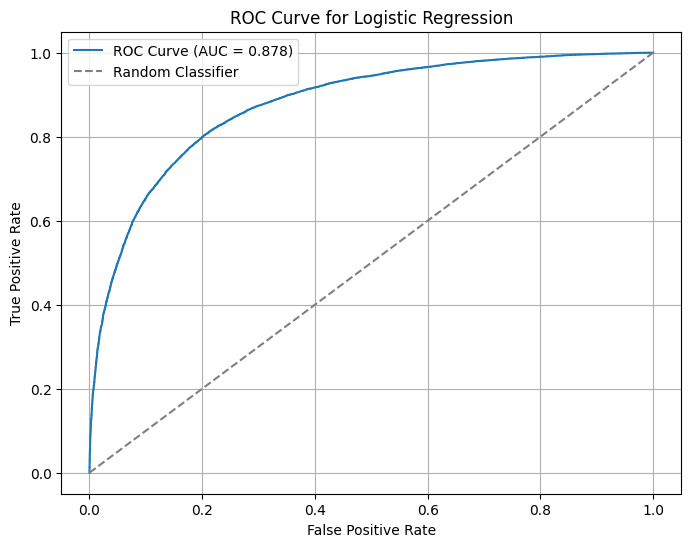

In [63]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
clf = LogisticRegression(max_iter=1500, random_state=42).fit(X_tfidf, y_train)
y_val_probs = clf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
auc_score = roc_auc_score(y_val, y_val_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
X_train = train_df["Text"]
y_train = train_df["Label"]

def objective(trial):
    max_features = trial.suggest_int("max_features", 55000, 70000)
    ngram_upper = trial.suggest_int("ngram_upper", 1, 3)
    min_df = trial.suggest_int("min_df", 1, 10)
    max_df = trial.suggest_float("max_df", 0.85, 1.0)
    C = trial.suggest_float("C", 0.5, 3.0, log=True)

    # Choose solver and penalty
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])

    # Ensure compatibility between solver and penalty
    if solver == "lbfgs" and penalty == "l1":
        raise optuna.exceptions.TrialPruned()

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, ngram_upper),
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=True
    )
    X_train_vec = vectorizer.fit_transform(X_train)

    model = LogisticRegression(
        C=C,
        max_iter=1500,
        random_state=42,
        solver=solver,
        penalty=penalty
    )

    scores = cross_val_score(model, X_train_vec, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_trial = study.best_trial
best_trial_params = best_trial.params
best_trial_value = best_trial.value

print("Best Hyperparameters:", best_trial_params)
print("Best F1 Score:", best_trial_value)


[I 2025-03-26 22:56:37,759] A new study created in memory with name: no-name-bc45fa43-fe57-49c8-85b6-4ffae10b02c3
[I 2025-03-26 22:56:37,763] Trial 0 pruned. 
[I 2025-03-26 22:57:03,916] Trial 1 finished with value: 0.8006900856062884 and parameters: {'max_features': 56399, 'ngram_upper': 3, 'min_df': 7, 'max_df': 0.9914279622606379, 'C': 1.079318012428445, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 1 with value: 0.8006900856062884.
[I 2025-03-26 22:57:11,180] Trial 2 finished with value: 0.7947953109029966 and parameters: {'max_features': 68983, 'ngram_upper': 1, 'min_df': 1, 'max_df': 0.9782663301393288, 'C': 1.0515098864807437, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.8006900856062884.
[I 2025-03-26 22:57:26,461] Trial 3 finished with value: 0.8016684107799753 and parameters: {'max_features': 56307, 'ngram_upper': 2, 'min_df': 8, 'max_df': 0.9669791728171224, 'C': 2.712965194622741, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 3 wi

Best Hyperparameters: {'max_features': 69382, 'ngram_upper': 3, 'min_df': 5, 'max_df': 0.8532445048895987, 'C': 1.4026124073425703, 'solver': 'lbfgs', 'penalty': 'l2'}
Best F1 Score: 0.8053642795757273


In [65]:
def objective(trial):
    max_features = trial.suggest_int("max_features", 61000, 68000, step=1000)
    ngram_upper = trial.suggest_int("ngram_upper", 2, 3)
    min_df = trial.suggest_int("min_df", 1, 3)
    max_df = trial.suggest_float("max_df", 0.90, 1, step=0.01)
    C = trial.suggest_float("C", 1.0, 2.0)
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, ngram_upper),
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=True,
        norm="l2"
    )
    X_train_vec = vectorizer.fit_transform(X_train)

    model = LogisticRegression(C=C, max_iter=1500, random_state=42, solver=solver, penalty="l2")
    scores = cross_val_score(model, X_train_vec, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

best_trial = study.best_trial
best_trial_params = best_trial.params
best_trial_value = best_trial.value

print("Best Hyperparameters:", best_trial_params)
print("Best F1 Score:", best_trial_value)

[I 2025-03-26 23:15:23,205] A new study created in memory with name: no-name-ea73616f-df6f-4e6e-95b2-15500b863799
[I 2025-03-26 23:15:49,554] Trial 0 finished with value: 0.8054781824243984 and parameters: {'max_features': 64000, 'ngram_upper': 3, 'min_df': 3, 'max_df': 1.0, 'C': 1.5371307118294897, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8054781824243984.
[I 2025-03-26 23:16:05,220] Trial 1 finished with value: 0.8036774354243738 and parameters: {'max_features': 62000, 'ngram_upper': 2, 'min_df': 3, 'max_df': 0.9400000000000001, 'C': 1.1272615348447692, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8054781824243984.
[I 2025-03-26 23:16:21,485] Trial 2 finished with value: 0.8041496646085348 and parameters: {'max_features': 63000, 'ngram_upper': 2, 'min_df': 1, 'max_df': 0.91, 'C': 1.655381775822136, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8054781824243984.
[I 2025-03-26 23:16:49,432] Trial 3 finished with value: 0.8052093979871362 and parameters: {'

Best Hyperparameters: {'max_features': 63000, 'ngram_upper': 3, 'min_df': 1, 'max_df': 0.99, 'C': 1.3980380797101684, 'solver': 'liblinear'}
Best F1 Score: 0.8055659153545631


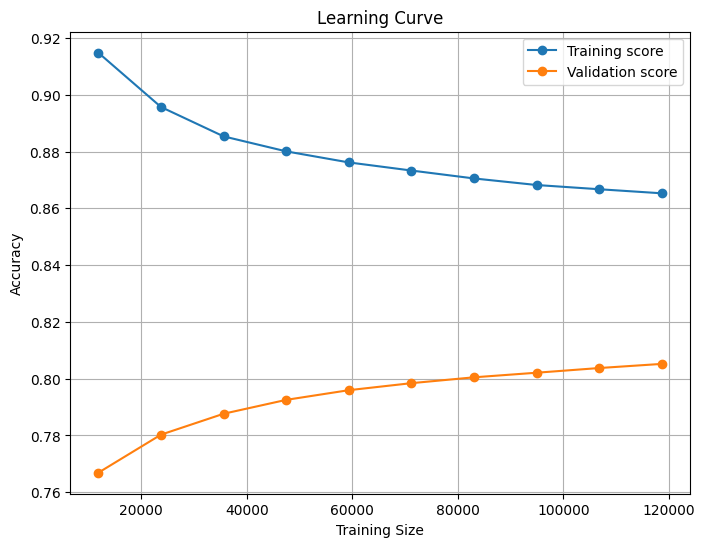

In [66]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer(max_features=67000, ngram_range=(1, 3), max_df=0.97, sublinear_tf=True, norm="l2")

X_tfidf = tfidf.fit_transform(X_train)
clf = LogisticRegression(C=1.3578686906704458, max_iter=1500, random_state=42, solver="liblinear", penalty="l2")
plot_learning_curve(clf, X_tfidf, y_train, cv=5, scoring='accuracy')


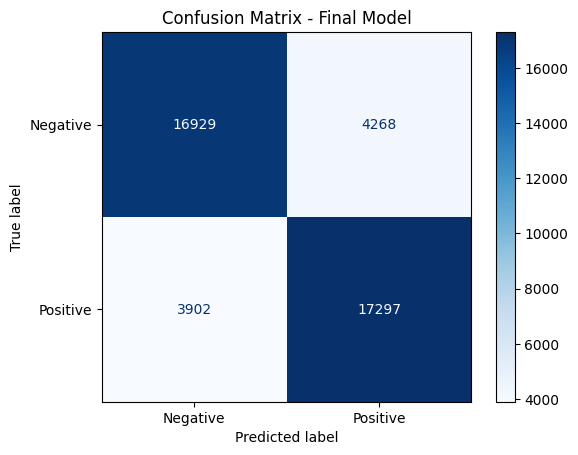

In [7]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer(max_features=67000, ngram_range=(1, 3), max_df=0.97, sublinear_tf=True, norm="l2")
X_tfidf = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
clf = LogisticRegression(C=1.3578686906704458, max_iter=1500, random_state=42, solver="liblinear", penalty="l2").fit(X_tfidf, y_train)
y_true = y_val  
y_pred = clf.predict(X_val)  

cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Final Model")
plt.savefig("confusion_matrix_final.png") 
plt.show()

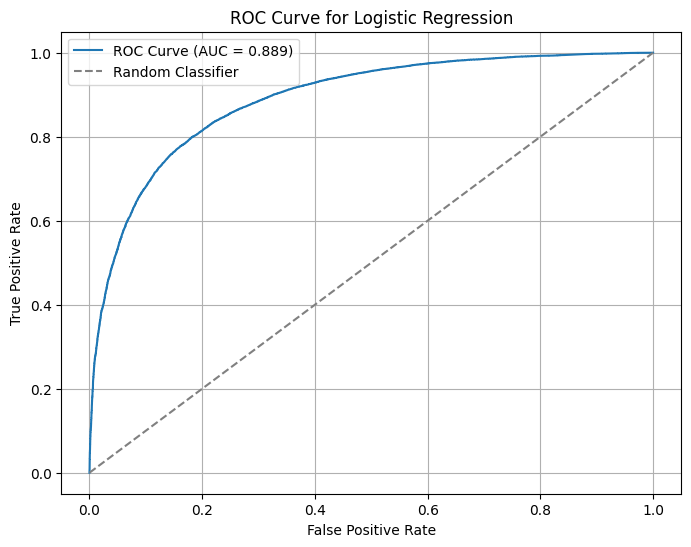

In [68]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/working/val_cleaned.csv")

X_train = train_df["Text"]
y_train = train_df["Label"]
X_val = val_df["Text"]
y_val = val_df["Label"]
tfidf = TfidfVectorizer(max_features=67000, ngram_range=(1, 3), max_df=0.97, sublinear_tf=True, norm="l2")
X_tfidf = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
clf = LogisticRegression(C=1.3578686906704458, max_iter=1500, random_state=42, solver="liblinear", penalty="l2").fit(X_tfidf, y_train)
y_val_probs = clf.predict_proba(X_val)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
auc_score = roc_auc_score(y_val, y_val_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [69]:
train_df = pd.read_csv("/kaggle/working/train_cleaned.csv")
test_df = pd.read_csv("/kaggle/working/test_cleaned.csv")

tfidf = TfidfVectorizer(max_features=67000, ngram_range=(1, 3), max_df=0.97, sublinear_tf=True, norm="l2")

x_train = tfidf.fit_transform(train_df['Text'])
x_test = tfidf.transform(test_df['Text'])

model = LogisticRegression(C=1.357, max_iter=1500, solver='liblinear', penalty='l2', random_state=42).fit(x_train, y_train)

y_test_pred = model.predict(x_test)
submission_df = pd.DataFrame({
    'ID': test_df['ID'], 
    'Label': y_test_pred  
})

submission_df.to_csv("submission.csv", index=False)